## Install BART (Should Only Run if you do not have BART)

In [72]:
# %%bash

# # Install BARTs dependencies
# apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev bc &> /dev/null

# # Clone Bart
# [ -d /content/bart ] && rm -r /content/bart
# git clone https://github.com/mrirecon/bart/ bart &> /dev/null

In [73]:
# %%bash

# BRANCH="master"

# cd bart

# # Switch to desired branch of the BART project
# git checkout -q $BRANCH

# # Define specifications
# COMPILE_SPECS="PARALLEL=1"

# printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# make &> /dev/null

## Setup BART Environment (Run every time you start your session)

In [74]:
import os
import sys

# Define environment variables for BART and OpenMP
os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

## Import Packages

In [24]:
from google.colab import drive
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
drive.mount('/content/drive')

from bart import bart
from cfl import writecfl,readcfl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


variables: dict_keys(['__header__', '__version__', '__globals__', 'brain_rspace'])
image shape: (256, 256)
image range 0.0 0.6


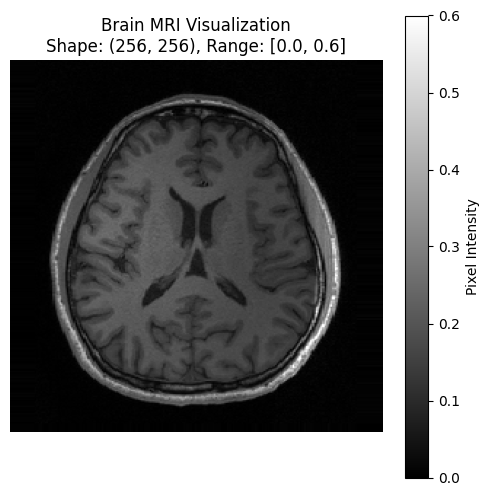

In [25]:
file_path ='/content/drive/My Drive/BIOE483/brain_rspace.mat'

mat_data = loadmat(file_path)

print("variables:", mat_data.keys())

image_data = mat_data.get('brain_rspace', None)

if image_data is not None:
    print("image shape:", image_data.shape)
    print("image range", np.min(image_data), np.max(image_data))

    plt.figure(figsize=(6, 6))
    plt.imshow(image_data, cmap='gray')  # 使用灰度色图
    plt.colorbar(label='Pixel Intensity')  # 添加颜色条
    plt.title(f"Brain MRI Visualization\nShape: {image_data.shape}, Range: [{np.min(image_data)}, {np.max(image_data)}]")
    plt.axis('off')  # 关闭坐标轴
    plt.show()
else:
    print("没有找到 'brain_rspace' 数据，请检查文件内容。")



In [26]:

if 'brain_rspace' in mat_data:  # 确认 'brain_rspace' 是否在变量中
    image_data = mat_data['brain_rspace']  # 加载变量

    # 检查数据的形状
    print("Image data shape:", image_data.shape)

    # 判断是单张图像还是多张图像
    if len(image_data.shape) == 3:  # 3D 数据 (num_images, height, width)
        num_images, height, width = image_data.shape
        print(f"Number of images: {num_images}, Image size: {height}x{width}")
    elif len(image_data.shape) == 4:  # 4D 数据 (num_images, height, width, channels)
        num_images, height, width, channels = image_data.shape
        print(f"Number of images: {num_images}, Image size: {height}x{width}, Channels: {channels}")
    else:  # 2D 数据 (height, width) 单张图像
        print("The data contains only one image.")
else:
    print("No 'brain_rspace' variable found in the .mat file.")


Image data shape: (256, 256)
The data contains only one image.


# Add noise to k-space data

In [27]:
import numpy as np
from numpy.fft import fft2, fftshift

k_space = fftshift(fft2(image_data))  # 中心化后的 k-space 数据

#add Gaussian noise
sigma = 0.05
noise_gaussian = np.random.normal(0, sigma, k_space.shape)
k_space_noisy_gaussian = k_space + noise_gaussian

#add Poisson noise
k_space_magnitude = np.abs(k_space)  # Take magnitude since Poisson requires non-negative values
noise_poisson = np.random.poisson(k_space_magnitude)  # Poisson noise
k_space_noisy_poisson = k_space + noise_poisson


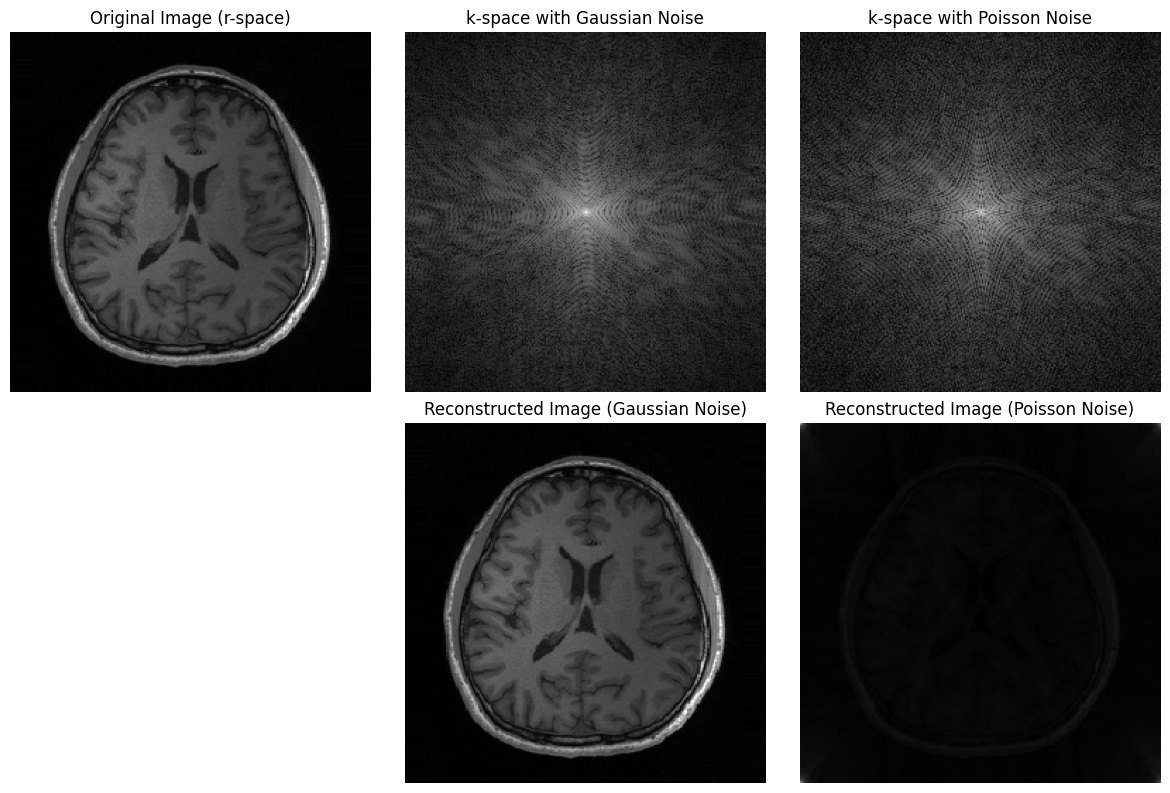

In [28]:
from numpy.fft import ifft2, ifftshift
import matplotlib.pyplot as plt

# reconstruct Gaussian noise image
reconstructed_image_gaussian = np.abs(ifft2(ifftshift(k_space_noisy_gaussian)))

#recontruct Poisson noise image
reconstructed_image_poisson = np.abs(ifft2(ifftshift(k_space_noisy_poisson)))

# 可视化结果
plt.figure(figsize=(12, 8))

# 原始图像
plt.subplot(2, 3, 1)
plt.imshow(image_data, cmap='gray')
plt.title("Original Image (r-space)")
plt.axis('off')

# 带噪声的 k-space
plt.subplot(2, 3, 2)
plt.imshow(np.log1p(np.abs(k_space_noisy_gaussian)), cmap='gray')
plt.title("k-space with Gaussian Noise")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.log1p(np.abs(k_space_noisy_poisson)), cmap='gray')
plt.title("k-space with Poisson Noise")
plt.axis('off')

# 重建图像
plt.subplot(2, 3, 5)
plt.imshow(reconstructed_image_gaussian, cmap='gray')
plt.title("Reconstructed Image (Gaussian Noise)")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(reconstructed_image_poisson, cmap='gray')
plt.title("Reconstructed Image (Poisson Noise)")
plt.axis('off')

plt.tight_layout()
plt.show()



# Traditional Denoising Methods

*   Gaussian Filtering
*   Mean Filtering
*   Median Filtering
*   FFT denoising(low-pass filtering)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy.fft import fft2, fftshift, ifft2, ifftshift

#low-pass filter:
def low_pass_filter(shape, radius):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2  # 中心点
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, -1)  # 创建圆形掩膜
    return mask

def apply_low_pass_filter(k_space, radius):
    mask = low_pass_filter(k_space.shape, radius)
    return k_space * mask

#median filter:
def apply_median_filter(k_space, kernel_size):
    real_part = cv2.medianBlur(np.real(k_space).astype(np.float32), kernel_size)
    imag_part = cv2.medianBlur(np.imag(k_space).astype(np.float32), kernel_size)
    return real_part + 1j * imag_part

#Gaussian filter:
def apply_gaussian_filter(k_space, kernel_size, sigma):
    real_part = cv2.GaussianBlur(np.real(k_space).astype(np.float32), (kernel_size, kernel_size), sigma)
    imag_part = cv2.GaussianBlur(np.imag(k_space).astype(np.float32), (kernel_size, kernel_size), sigma)
    return real_part + 1j * imag_part


In [30]:
# 去噪处理
radius = 30  # 低通滤波器半径
kernel_size = 5 # 中值和高斯滤波器大小
sigma_gaussian = 1  # 高斯滤波器标准差

# 对高斯噪声处理
k_space_gaussian_lowpass = apply_low_pass_filter(k_space_noisy_gaussian, radius)
k_space_gaussian_median = apply_median_filter(k_space_noisy_gaussian, kernel_size)
k_space_gaussian_gaussian = apply_gaussian_filter(k_space_noisy_gaussian, kernel_size, sigma_gaussian)

# 对泊松噪声处理
k_space_poisson_lowpass = apply_low_pass_filter(k_space_noisy_poisson, radius)
k_space_poisson_median = apply_median_filter(k_space_noisy_poisson, kernel_size)
k_space_poisson_gaussian = apply_gaussian_filter(k_space_noisy_poisson, kernel_size, sigma_gaussian)


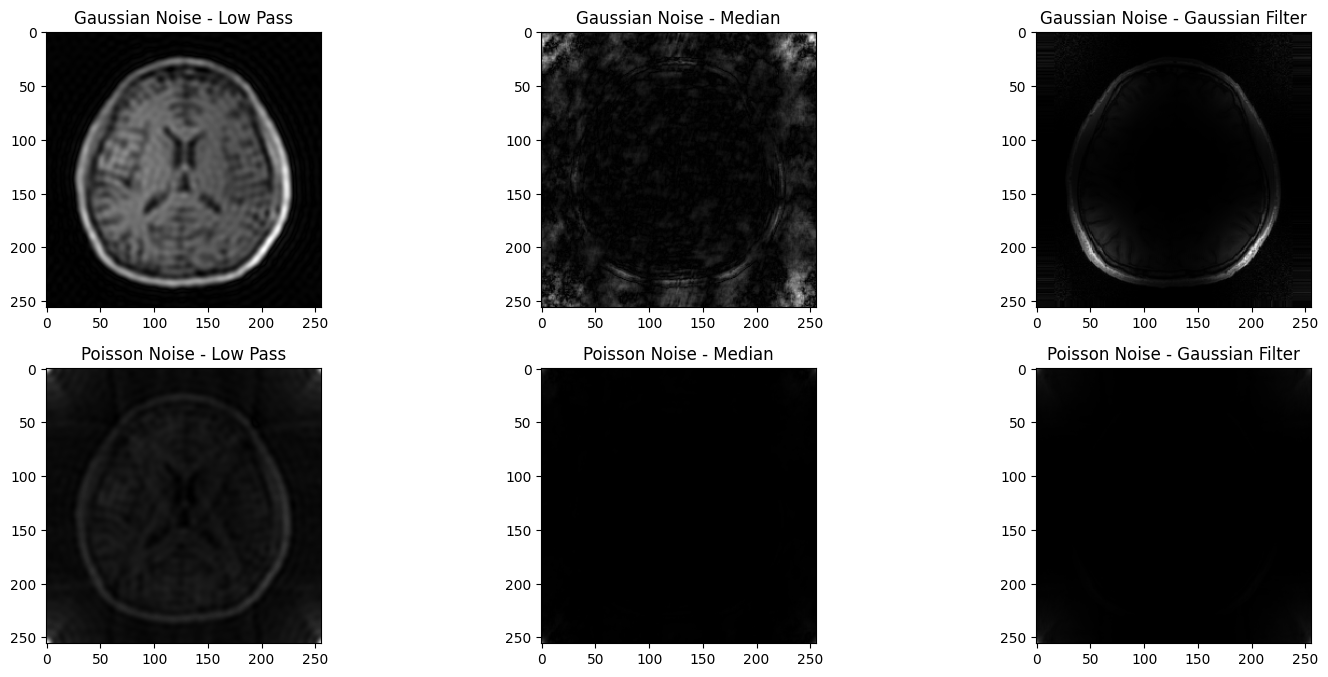

In [31]:
# 还原到 r-space
def restore_image(k_space):
    return np.abs(ifft2(ifftshift(k_space)))

denoised_image_gaussian_lowpass = restore_image(k_space_gaussian_lowpass)
denoised_image_gaussian_median = restore_image(k_space_gaussian_median)
denoised_image_gaussian_gaussian = restore_image(k_space_gaussian_gaussian)

denoised_image_poisson_lowpass = restore_image(k_space_poisson_lowpass)
denoised_image_poisson_median = restore_image(k_space_poisson_median)
denoised_image_poisson_gaussian = restore_image(k_space_poisson_gaussian)

# 可视化结果
plt.figure(figsize=(15, 10))

# 高斯噪声处理结果
plt.subplot(3, 3, 1)
plt.title("Gaussian Noise - Low Pass")
plt.imshow(denoised_image_gaussian_lowpass, cmap='gray')

plt.subplot(3, 3, 2)
plt.title("Gaussian Noise - Median")
plt.imshow(denoised_image_gaussian_median, cmap='gray')

plt.subplot(3, 3, 3)
plt.title("Gaussian Noise - Gaussian Filter")
plt.imshow(denoised_image_gaussian_gaussian, cmap='gray')

# 泊松噪声处理结果
plt.subplot(3, 3, 4)
plt.title("Poisson Noise - Low Pass")
plt.imshow(denoised_image_poisson_lowpass, cmap='gray')

plt.subplot(3, 3, 5)
plt.title("Poisson Noise - Median")
plt.imshow(denoised_image_poisson_median, cmap='gray')

plt.subplot(3, 3, 6)
plt.title("Poisson Noise - Gaussian Filter")
plt.imshow(denoised_image_poisson_gaussian, cmap='gray')

plt.tight_layout()
plt.show()

# PSNR and SSIM for traditional denosing method

In [32]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# 定量评估函数
def evaluate_metrics(original, denoised):
    psnr_value = psnr(original, denoised, data_range=original.max() - original.min())
    ssim_value = ssim(original, denoised, data_range=original.max() - original.min())
    return psnr_value, ssim_value

# 计算 PSNR 和 SSIM
metrics = {
    "Gaussian Noise": {
        "Low Pass": evaluate_metrics(image_data, denoised_image_gaussian_lowpass),
        "Median": evaluate_metrics(image_data, denoised_image_gaussian_median),
        "Gaussian Filter": evaluate_metrics(image_data, denoised_image_gaussian_gaussian),
    },
    "Poisson Noise": {
        "Low Pass": evaluate_metrics(image_data, denoised_image_poisson_lowpass),
        "Median": evaluate_metrics(image_data, denoised_image_poisson_median),
        "Gaussian Filter": evaluate_metrics(image_data, denoised_image_poisson_gaussian),
    }
}

# 打印结果
for noise_type, methods in metrics.items():
    print(f"\n{noise_type}:")
    for method, (psnr_value, ssim_value) in methods.items():
        print(f"{method} - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")



Gaussian Noise:
Low Pass - PSNR: 28.01, SSIM: 0.81
Median - PSNR: 13.72, SSIM: 0.29
Gaussian Filter - PSNR: 13.80, SSIM: 0.34

Poisson Noise:
Low Pass - PSNR: 13.59, SSIM: 0.38
Median - PSNR: 13.20, SSIM: 0.26
Gaussian Filter - PSNR: 11.92, SSIM: 0.21


# Compressed Sensing



### Simulating  Undersampled  k-space data

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift

def random_stripe_sampling(shape, center_fraction=0.1, acceleration=4):
    """
    生成模拟 MRI 欠采样的二维掩码，结合中心列完全采样和随机条纹采样。

    参数:
        shape (tuple): 掩码的形状（例如二维图像的 shape，如 (128, 128)）。
        center_fraction (float): 中心列的采样比例 (0 < center_fraction < 1)。
        acceleration (int): 欠采样加速因子，控制整体采样的稀疏性。

    返回:
        np.ndarray: 二维掩码，值为 0 或 1。
    """
    num_rows, num_cols = shape

    # 初始化掩码为全 0
    mask = np.zeros((num_rows, num_cols), dtype=np.float32)

    # 1. 中心列采样
    num_low_freq_cols = int(num_cols * center_fraction)
    start_col = (num_cols - num_low_freq_cols) // 2
    end_col = start_col + num_low_freq_cols
    mask[:, start_col:end_col] = 1  # 对中心列完全采样

    # 2. 随机条纹采样（控制加速因子）
    # 剩余采样列数：确保总采样数符合加速因子要求
    total_samples = int(num_cols / acceleration)
    remaining_samples = max(0, total_samples - num_low_freq_cols)

    # 生成随机条纹索引
    random_cols = np.random.choice(
        [i for i in range(num_cols) if i < start_col or i >= end_col],  # 排除中心列
        size=remaining_samples,
        replace=False
    )

    # 将随机选择的条纹设置为采样
    mask[:, random_cols] = 1

    return mask



In [34]:
def random_sampling(shape, sampling_ratio):
    """
    生成一个随机采样的二值掩码（Mask）。

    参数：
    - shape: tuple, 掩码的形状（如 (128, 128)）。
    - sampling_ratio: float, 采样率（例如 0.3 表示采样点占 30%）。

    返回：
    - mask: ndarray, 二值掩码，值为 0 或 1。
    """
    # 随机生成 [0, 1) 的均匀分布
    random_matrix = np.random.rand(*shape)

    # 根据采样率生成二值掩码
    mask = (random_matrix < sampling_ratio).astype(np.float32)

    return mask

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifft2, ifftshift


def reconstructed_image_func(k_space):
  return np.abs(ifft2(ifftshift(k_space)))

def visualize_kspace_and_image(k_space):
    """
    Visualizes the given k-space data and its reconstructed image.

    Args:
        k_space (numpy.ndarray): 2D complex-valued k-space data.
    """
    # Compute the magnitude of k-space and apply log for visualization
    kspace_magnitude = np.log(np.abs(k_space) + 1e-9)

    # Reconstruct the image using inverse FFT
    reconstructed_image = reconstructed_image_func(k_space)  # Perform inverse FFT and shift to center
    image_magnitude = np.abs(reconstructed_image)  # Take the magnitude for visualization

    # Calculate PSNR and SSIM
    psnr_value, ssim_value = evaluate_metrics(image_data, image_magnitude)

    # Plot the k-space magnitude
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(kspace_magnitude, cmap='gray')
    plt.title("k-space (Log Magnitude)")
    plt.colorbar()
    plt.axis("off")

    # Plot the reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(image_magnitude, cmap='gray')
    plt.title("Reconstructed Image")
    plt.colorbar()
    plt.axis("off")

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Print PSNR and SSIM
    print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")


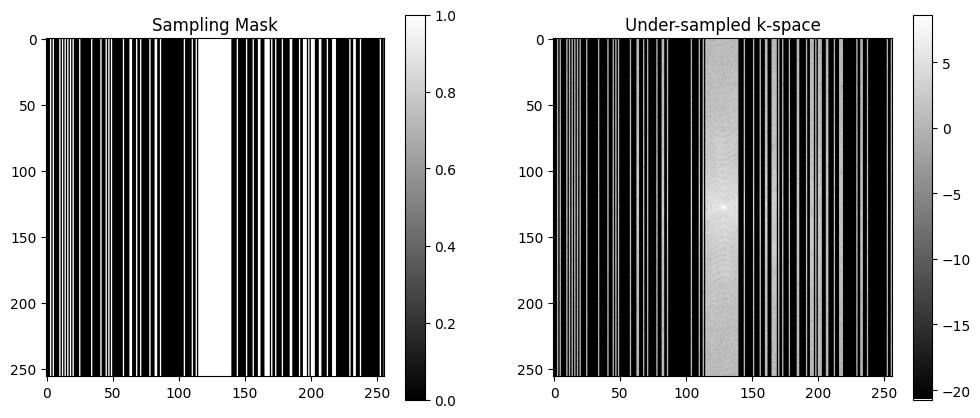

In [36]:
# Generate a sampling mask
random_stripe_mask = random_stripe_sampling(k_space.shape, center_fraction=0.1, acceleration=3)
random_mask = random_sampling(k_space.shape,0.5)

# Apply the mask to the k-space data
random_stripe_mask_k_space = k_space * random_stripe_mask
random_mask_k_space = k_space * random_mask

# Visualize the sampling mask and undersampled k-space
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(random_stripe_mask, cmap='gray')
plt.title("Sampling Mask")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log(np.abs(random_stripe_mask_k_space) + 1e-9), cmap='gray')
plt.title("Under-sampled k-space")
plt.colorbar()
plt.show()

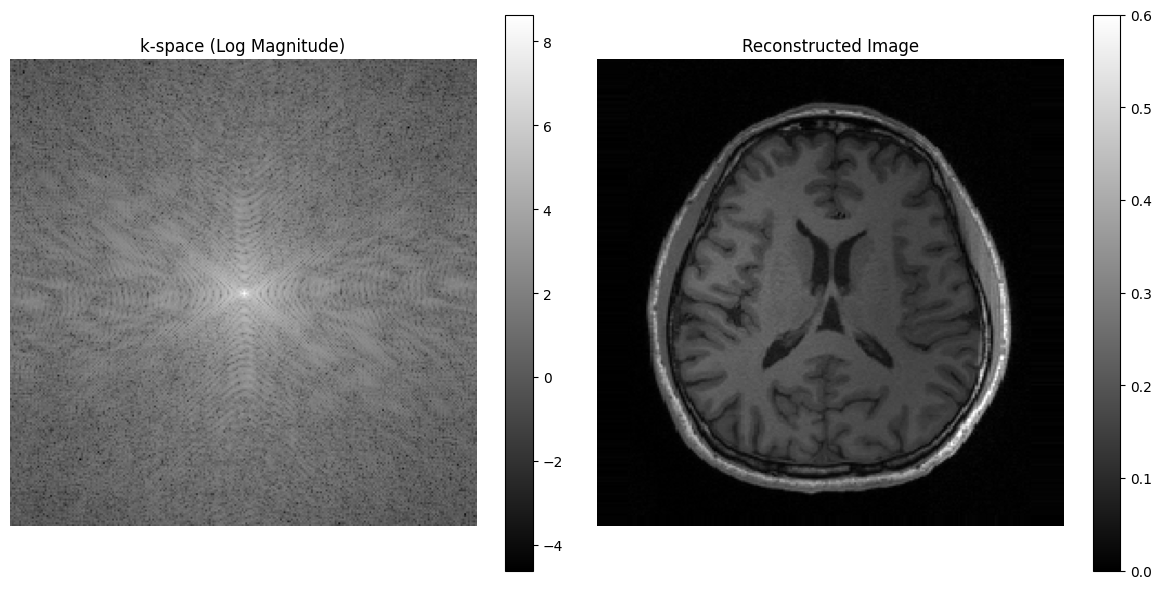

PSNR: 324.14, SSIM: 1.00


In [37]:
import numpy as np
from numpy.fft import fft2, fftshift

mat_data = loadmat(file_path)
image_data = mat_data.get('brain_rspace', None)
k_space = fftshift(fft2(image_data))
visualize_kspace_and_image(k_space)

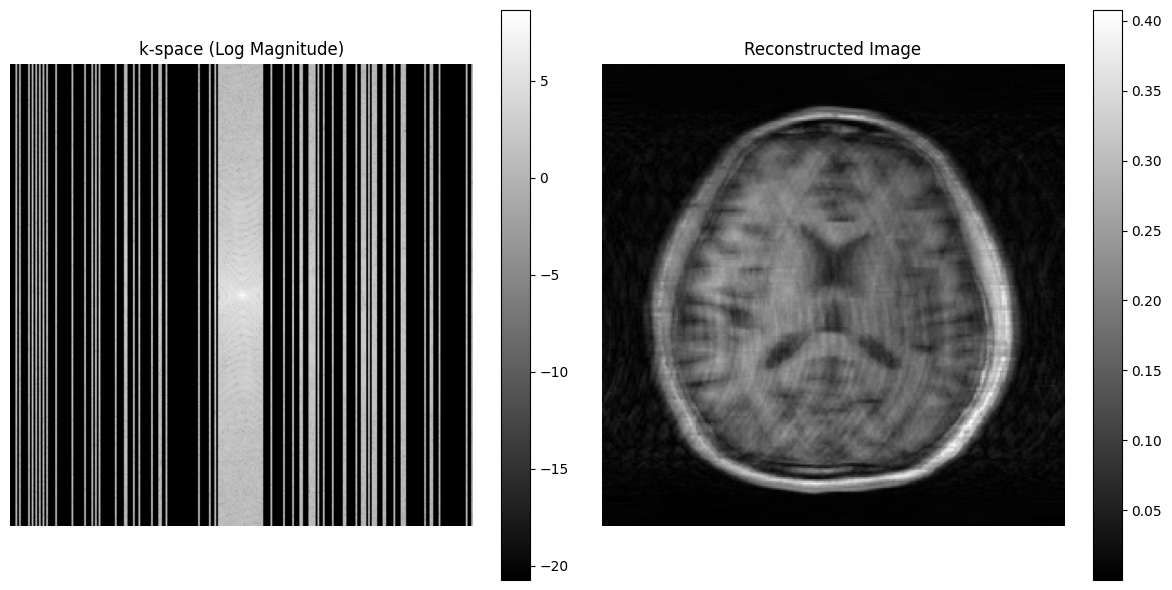

PSNR: 26.65, SSIM: 0.71


In [39]:
visualize_kspace_and_image(random_stripe_mask_k_space)

### Zero-filling

In [49]:
# Reconstruct the image using IRLS
mat_data = loadmat(file_path)
image_data = mat_data.get('brain_rspace', None)
k_space = fftshift(fft2(image_data))

mask = random_stripe_sampling(k_space.shape, center_fraction=0.1, acceleration=3)
# mask = random_sampling(k_space.shape,0.5)

undersampled_k_space = k_space * mask # zero_filling_reconstruction


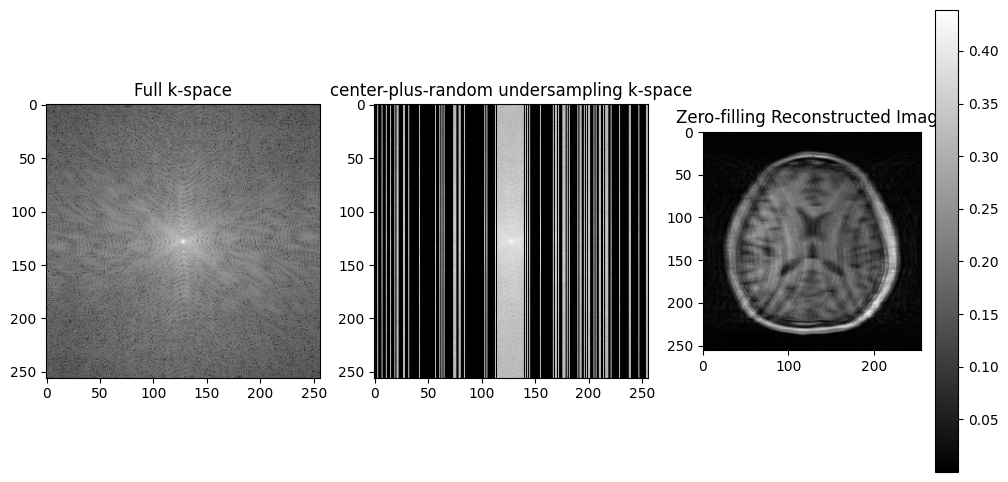

Reconstructed Image PSNR: 26.65, SSIM: 0.72


In [58]:
# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.log(np.abs(k_space) + 1e-9), cmap='gray')
plt.title("Full k-space")

plt.subplot(1, 3, 2)
plt.imshow(np.log(np.abs(k_space*mask) + 1e-9), cmap='gray')
plt.title("center-plus-random undersampling k-space")


reconstructed_image = reconstructed_image_func(undersampled_k_space)  # Perform inverse FFT and shift to center
image_magnitude = np.abs(reconstructed_image)  # Take the magnitude for visualization

plt.subplot(1, 3, 3)
plt.imshow(image_magnitude, cmap='gray')
plt.title("Zero-filling Reconstructed Image")
plt.colorbar()
plt.show()

#Compute PSNR and SSIM
psnr_value, ssim_value = evaluate_metrics(image_data, image_magnitude)

# Print PSNR and SSIM
print(f"Reconstructed Image PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")

(-0.5, 255.5, 255.5, -0.5)

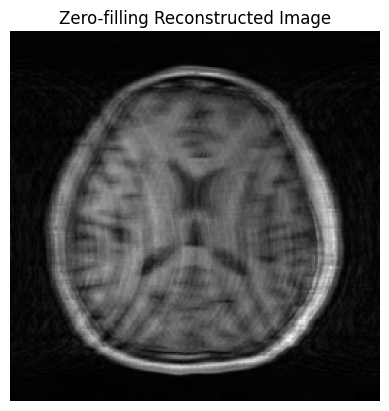

In [59]:
plt.imshow(image_magnitude, cmap='gray')
plt.title("Zero-filling Reconstructed Image")
plt.axis('off')

### Iterative Soft Thresholding Algorithm (ISTA)


In [60]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift

def compressed_sensing_irls(k_space, mask, max_iter=50, tol=1e-5, lambda_reg=0.1, beta=1e-8):
    """
    基于迭代加权L2的MRI压缩感知重建算法。

    参数：
    - k_space: ndarray, 欠采样的K空间数据，复数数组。
    - mask: ndarray, 二值掩码，指示哪些点被采样。
    - max_iter: int, 最大迭代次数。
    - tol: float, 收敛阈值，控制停止条件。
    - lambda_reg: float, 正则化参数，控制稀疏性。
    - beta: float, 平滑参数，避免除以零。

    返回：
    - reconstructed_image: ndarray, 重建后的图像。
    """
    # 初始化
    rho = k_space.copy()  # 初始信号，使用K空间数据
    weights = np.ones_like(rho, dtype=np.float32)  # 初始化权重矩阵

    for iter_num in range(max_iter):
        # 从K空间转换到图像域
        x_img = fftshift(ifft2(ifftshift(rho)))

        # 更新权重矩阵
        abs_img = np.abs(x_img)
        weights = 1 / np.sqrt(abs_img**2 + beta)

        # 加权软阈值化
        x_img = np.sign(x_img) * np.maximum(abs_img - lambda_reg * weights, 0)

        # 从图像域转换回K空间
        updated_k_space = fftshift(fft2(ifftshift(x_img)))

        # 保持数据一致性（强制采样点与原始数据相符）
        rho = mask * k_space + (1 - mask) * updated_k_space

        # 检查收敛条件
        if np.linalg.norm(updated_k_space - rho) < tol:
            print(f"在第 {iter_num + 1} 次迭代时收敛。")
            break
    print(iter_num)


    return rho



In [61]:
# Reconstruct the image using IRLS
mat_data = loadmat(file_path)
image_data = mat_data.get('brain_rspace', None)
k_space = fftshift(fft2(image_data))

mask = random_stripe_sampling(k_space.shape, center_fraction=0.1, acceleration=3)
# mask = random_sampling(k_space.shape,0.5)

undersampled_k_space = k_space * mask
reconstructed_k_space = compressed_sensing_irls(undersampled_k_space, mask, max_iter=20, tol=1e-5, lambda_reg=1e-4)


19


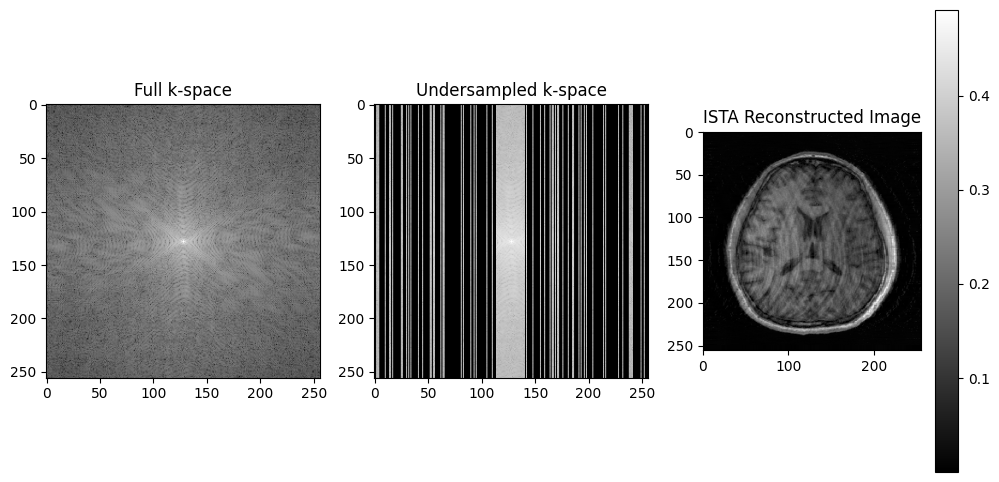

Reconstructed Image PSNR: 29.23, SSIM: 0.81


In [62]:
# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.log(np.abs(k_space) + 1e-9), cmap='gray')
plt.title("Full k-space")

plt.subplot(1, 3, 2)
plt.imshow(np.log(np.abs(k_space*mask) + 1e-9), cmap='gray')
plt.title("Undersampled k-space")


reconstructed_image = reconstructed_image_func(reconstructed_k_space)  # Perform inverse FFT and shift to center
image_magnitude = np.abs(reconstructed_image)  # Take the magnitude for visualization

plt.subplot(1, 3, 3)
plt.imshow(image_magnitude, cmap='gray')
plt.title("ISTA Reconstructed Image")
plt.colorbar()
plt.show()

#Compute PSNR and SSIM
psnr_value, ssim_value = evaluate_metrics(image_data, image_magnitude)

# Print PSNR and SSIM
print(f"Reconstructed Image PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")

(-0.5, 255.5, 255.5, -0.5)

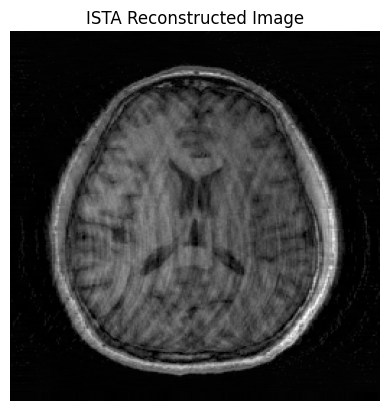

In [63]:
plt.imshow(image_magnitude, cmap='gray')
plt.title("ISTA Reconstructed Image")
plt.axis('off')

## Use BART to Compressed Sensing

In [65]:
import numpy as np
from numpy.fft import fft2, fftshift

mat_data = loadmat(file_path)

print("variables:", mat_data.keys())

rspace = mat_data.get('brain_rspace', None)
kspace = fftshift(fft2(rspace))


variables: dict_keys(['__header__', '__version__', '__globals__', 'brain_rspace'])


In [66]:
random_stripe_mask = random_stripe_sampling(kspace.shape, center_fraction=0.1, acceleration=3)
random_stripe_mask_kspace = kspace * random_stripe_mask


In [75]:
sens_maps = bart(1, "ecalib -d0 -m1", random_stripe_mask_kspace)

In [96]:
reg_wt = 1e-2
num_iters = 200
pred = bart(
        1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", random_stripe_mask_kspace, sens_maps
    )

(-0.5, 255.5, 255.5, -0.5)

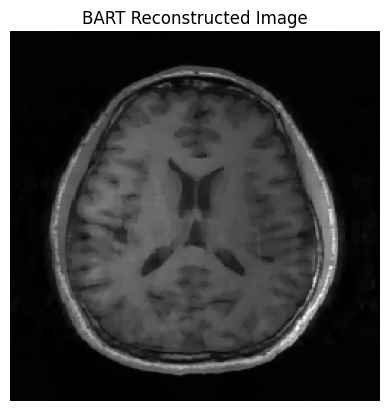

In [98]:
plt.imshow(np.abs(fftshift(pred)),cmap = "gray")
plt.title("BART Reconstructed Image")
plt.axis('off')

# Combine Compressed Sensing and Denoising

In [ ]:
print(f"Shape of undersampled_k_space: {undersampled_k_space.shape}")


## Denoise using undersampled k-space data

In [ ]:
# Combined denoise and compressed sensing implementation

# apply_low_pass_filter, apply_median_filter, apply_gaussian_filter

# Step 1: Undersample k-space data
mask = random_mask_func(k_space.shape, center_fraction=0.04, acceleration=8)
undersampled_k_space = k_space * mask

# Step 2: 使用不同滤波器进行去噪
filters = {
    "Low Pass": lambda k: apply_low_pass_filter(k, radius=30),
    "Median": lambda k: apply_median_filter(k, kernel_size=5),
    "Gaussian": lambda k: apply_gaussian_filter(k, kernel_size=5, sigma=1),
}

reconstructed_images = {}
metrics_results = {}

for filter_name, filter_func in filters.items():
    # Apply the filter to the undersampled k-space
    denoised_k_space = filter_func(undersampled_k_space)

    # Step 3: Perform sparse reconstruction using IRLS
    reconstructed_k_space = iterative_reweighted_least_squares(
        denoised_k_space, mask, max_iter=30, p=0.8, tol=1e-6
    )

    # Step 4: Convert reconstructed k-space back to image space
    reconstructed_image = reconstructed_image_func(reconstructed_k_space)
    reconstructed_images[filter_name] = reconstructed_image

    # Step 5: Evaluate PSNR and SSIM
    psnr_value, ssim_value = evaluate_metrics(image_data, reconstructed_image)
    metrics_results[filter_name] = (psnr_value, ssim_value)

# 可视化结果
plt.figure(figsize=(15, 10))

for idx, (filter_name, reconstructed_image) in enumerate(reconstructed_images.items(), start=1):
    plt.subplot(2, 3, idx)
    plt.imshow(np.abs(reconstructed_image), cmap='gray')
    plt.title(f"{filter_name} Filter\nPSNR: {metrics_results[filter_name][0]:.2f}, SSIM: {metrics_results[filter_name][1]:.2f}")
    plt.colorbar()

plt.tight_layout()
plt.show()

# 打印定量评估结果
print("PSNR 和 SSIM 结果:")
for filter_name, (psnr_value, ssim_value) in metrics_results.items():
    print(f"{filter_name} Filter - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")


## Denoise after IRLS

In [ ]:
filters = {
    "Low Pass": lambda img: apply_low_pass_filter(fftshift(fft2(img)), radius=30),
    "Median": lambda img: apply_median_filter(fftshift(fft2(img)), kernel_size=5),
    "Gaussian": lambda img: apply_gaussian_filter(fftshift(fft2(img)), kernel_size=5, sigma=1),
}

# 结果存储
denoised_images = {}
metrics_results = {}

for filter_name, filter_func in filters.items():
    # Step 1: 转换到 k-space 并应用滤波器
    filtered_k_space = filter_func(reconstructed_image)

    # Step 2: 转换回 r-space
    filtered_image = np.abs(ifft2(ifftshift(filtered_k_space)))
    denoised_images[filter_name] = filtered_image

    # Step 3: 计算 PSNR 和 SSIM
    psnr_value, ssim_value = evaluate_metrics(image_data, filtered_image)
    metrics_results[filter_name] = (psnr_value, ssim_value)

# 可视化结果
plt.figure(figsize=(15, 10))

for idx, (filter_name, filtered_image) in enumerate(denoised_images.items(), start=1):
    plt.subplot(2, 3, idx)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f"{filter_name} Filter\nPSNR: {metrics_results[filter_name][0]:.2f}, SSIM: {metrics_results[filter_name][1]:.2f}")
    plt.colorbar()

plt.tight_layout()
plt.show()

# 打印定量评估结果
print("PSNR 和 SSIM 结果:")
for filter_name, (psnr_value, ssim_value) in metrics_results.items():
    print(f"{filter_name} Filter - PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")
